In [67]:
from itertools import combinations
import numpy as np
from sklearn.neighbors import NearestNeighbors, KDTree
import matplotlib.pyplot as plt
from functools import reduce
from scipy.special import digamma
import pandas as pd
from sklearn.feature_selection import mutual_info_regression
import seaborn as sns
plt.style.use('fivethirtyeight')

# M-Dimensional Estimator For Mutual Information

This notebook presents an extension for computing the estimator of mutual information between 2 random variables to m random variables. Sklearn has a function for such a 2-dimensional problem called `mutual_info_regression`. The source code is modified such that we can take a $p$ dimensional design matrix and estimate the mutual information between $m$ predictors and the target. The estimator can be found in the following paper: https://journals.aps.org/pre/pdf/10.1103/PhysRevE.69.066138

## Mutual Information of Two Random Variables

$$I(X;Y) = \int \int p_{X, Y}(x, y) \log \frac{p_{X, Y}(x, y)}{p_X(x)p_Y(y)}$$

Notice that this takes the shape of the [Kullback-Leibler Divergence](https://en.wikipedia.org/wiki/Kullback%E2%80%93Leibler_divergence). Also recall that if $X$ and $Y$ are completely independent, then the joint probability distribution is the product of the marginals. In this case, indepedent continuous random variables yield a mutual information of 0, which can be observed above.

### A 2-Dimensional Estimator of Mutual Information

$$I(X, Y) = \psi(k) + \psi(N) - \langle \psi(n_{x_1 + 1}) + \psi(n_{y + 1})\rangle$$

Suppose $Z = (X, Y)$

where

- $\psi(x)$ is the digamma function

- $k$ is the number of nearest neighbors

- $m$ is the number if dimensions

- $N$ is the number of samples

- $n_{x_i}$ is the number of points $x_j$ strictly less than the radius, where the radius is the distance from $z_i$ to its $k^{th}$ neighbor. 

As shown in the paper, the authors propose an estimator from a nearest-neighbor approach which diverges from the traditional binning approach. They then briefly mention an extension for an M-dimensional estiamtor, which is given below.



### Why Mutual Information and Not Correlation?

Mutual information is a far more sensitive metric for univariate screening than correlation. Mutual information will be able to capture any strong correlation, while a correlation may miss a strong dependency between two variables. We can examine this below.

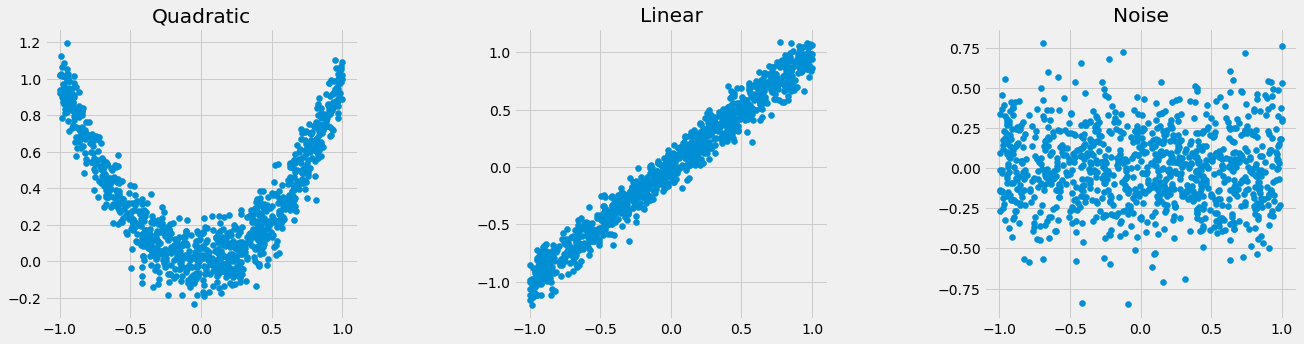

In [59]:
n = 1000
x = np.random.uniform(-1, 1, size = n)
y = x ** 2 + np.random.normal(scale = 0.1, size = n)
y2 = x + np.random.normal(scale = 0.1, size = n)
y3 = np.random.normal(scale = 0.25, size = n)

plt.figure(figsize = (20, 5))
plt.subplots_adjust(hspace = 0.4, wspace = 0.5)
plt.subplot(1, 3, 1)
plt.scatter(x, y)
plt.title('Quadratic')

plt.subplot(1, 3, 2)
plt.scatter(x, y2)
plt.title('Linear')

plt.subplot(1, 3, 3)
plt.scatter(x, y3)
plt.title('Noise')
plt.show()

### Correlation

In [60]:
for i in [y, y2, y3]:
    print(np.corrcoef(x, i)[0, 1])


-0.054275957615103114
0.9855776322740627
-0.0261409865721133


### Mutual Information

In [62]:
for i in [y, y2, y3]:
    print(_compute_mi_cc(x, i))

1.0624308329398628
1.7128133659935139
0.005254171116765072


### An M-Dimensional Estimator of Mutual Information

$$I(X_1, X_2,...,X_m) = \psi(k) + (m-1)\psi(N) - \langle \psi(n_{x_1}) + \psi(n_{x_2}) + ... + \psi(n_{x_m}) \rangle$$

Suppose $Z = (X_1, X_2,...,X_m)$

where

- $\psi(x)$ is the digamma function

- $k$ is the number of nearest neighbors

- $m$ is the number if dimensions

- $N$ is the number of samples

- $n_{x_i}$ is the number of points $x_j$ strictly less than the radius, where the radius is the distance from $z_i$ to its $k^{th}$ neighbor. 

# Implementation

The code below modifies the source code from sklearn's `mutual_info_regression` for a 2-dimensional estimator to correspond to the M-dimensional estimator given in the paper.

### A 2-Dimension Primer

Below is the source code from sklearn's `mutual_info_regression` for a 2-dimensional estimator.

In [61]:
def _compute_mi_cc(x, y, n_neighbors = 3):

    n_samples = x.size

    x = x.reshape((-1, 1))
    y = y.reshape((-1, 1))
    xy = np.hstack((x, y))

    # Here we rely on NearestNeighbors to select the fastest algorithm.
    nn = NearestNeighbors(metric='chebyshev', n_neighbors=n_neighbors)

    nn.fit(xy)
    radius = nn.kneighbors()[0]
    radius = np.nextafter(radius[:, -1], 0)

    # KDTree is explicitly fit to allow for the querying of number of
    # neighbors within a specified radius
    kd = KDTree(x, metric='chebyshev')
    nx = kd.query_radius(x, radius, count_only=True, return_distance=False)
    nx = np.array(nx) - 1.0

    kd = KDTree(y, metric='chebyshev')
    ny = kd.query_radius(y, radius, count_only=True, return_distance=False)
    ny = np.array(ny) - 1.0

    mi = (digamma(n_samples) + digamma(n_neighbors) -
          np.mean(digamma(nx + 1)) - np.mean(digamma(ny + 1)))

    return max(0, mi)

We can extend the above function with some slight modifications to account for m-dimensions. (I also incorporate some of my own idiosyncratic coding practices).

In [63]:
def compute_mi_cc(X, y, N, n_neighbors):
    
    m = X.shape[1]
    Z = np.hstack((X, y))
    
    ### Instantiate the Nearest Neighbor model (note the chebyshev distance!!)
    nn = NearestNeighbors(metric = 'chebyshev', n_neighbors = n_neighbors)
    
    ### Fit Z
    nn.fit(Z)
    
    ### Find the distance to the k-nearest neighbor for each point in Z
    radius = nn.kneighbors()[0]
    radius = np.nextafter(radius[:, -1], 0)
    
    ### This will be a list of arrays that record the number of neighbors within each radius for each point for each X
    neighbors = []
    
    ### Iterate through the columns of Z (which includes y!)
    for i in range(Z.shape[1]):
        
        ### Reshape the array
        Z_i = Z[ : , i].reshape((-1, 1))
        
        ### Instantiate the Tree (note the chebyshev distance!!)
        kd = KDTree(Z_i, metric = 'chebyshev')
        
        ### Find number of neighbors within the radius
        n_i = kd.query_radius(Z_i, radius, count_only = True, return_distance = False)
        
        ### Subtract 1 so as not count the point itself
        neighbors.append( - 1)

    ### Function for computing the mean of the digamma of the neighbors
    digamma_mean = lambda x : np.mean(digamma(x + 1))
    
    ### Final Mutual Information Estimate
    mi = digamma(n_neighbors) + m * digamma(N) - sum(list(map(digamma_mean, neighbors)))
    
    ### If the estimate is less than 0, just return 0
    return max(0, mi)

The function below is just a wrapper for the above function.

In [64]:
def m_dim_mi(X, y, m = 2, n_neighbors = 3):
    
    p = X.shape[1]
    
    ### Find all combinations of p of size m
    all_pairs = list(combinations(range(p), m))
    
    ### Reshape y to two dimensions
    y = y.reshape((-1, 1))
    
    ### Number of samples
    N = y.size
    
    ### Compute Mutual Information Estimate for all pairs 
    mis = [compute_mi_cc(X[ : , pair], y, N, n_neighbors) for pair in all_pairs]
    
    return mis

## Why M-dimension mutual information?

The short answer is interactions. An M-way interaction can be detected with M-way mutual information as we will illustrate below.

### Data Generation

We will simulate some data in the following fashion, where two features interact.

Let $$X = (x_1, ... , x_3)$$

where

$$X \sim U(-1, 1)$$

and 

$$Y = 10\exp \left(\frac{x_2}{2}\right) \cos(\pi x_1) + \epsilon$$

where

$$\epsilon \sim N(0, 1)$$

In [645]:
p = 3
n = 10000
X = np.random.uniform(-1, 1, size = (n, p))
y = 10 * np.exp(X[:, 1] / 2) * np.cos(X[:, 0] * np.pi) + np.random.normal(scale = 1, size = n)

### Plot Data

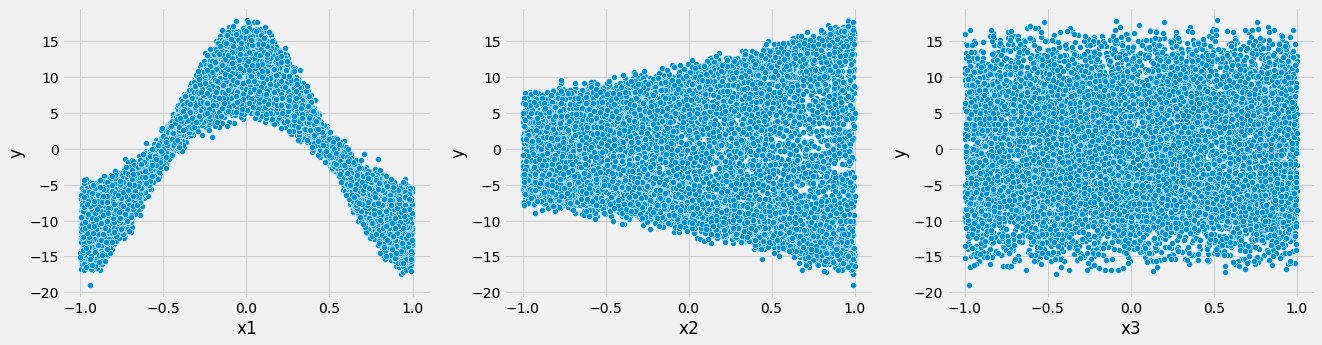

In [663]:
df = pd.DataFrame(np.hstack((X, y.reshape((-1, 1)))))
df.columns = ['x' + str(i) for i in range(1, p + 1)] + ['y']

plt.figure(figsize = (20, 5))

for i in range(1, 4):

    plt.subplot(1, 3, i)
    sns.scatterplot(x = 'x' + str(i), y = 'y', data = df)

### Visualize Interaction Effect

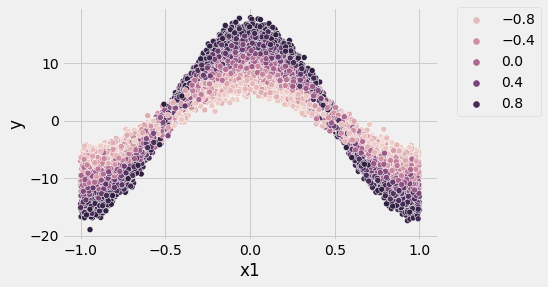

In [658]:
sns.scatterplot(x = 'x1', y = 'y', hue = 'x2', data = df)
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left', borderaxespad=0)

## Correlation

In [659]:
df.corr()

,x1,x2,x3,y
x1,1.000000,-0.008073,0.005964,-0.006634
x2,-0.008073,1.000000,-0.007883,0.003313
x3,0.005964,-0.007883,1.000000,0.003878
y,-0.006634,0.003313,0.003878,1.000000


### 2-Dimensional Mutual Information

In [661]:
X_new = df.copy()
y_new = X_new.pop('y')
discrete_features = X_new.dtypes == int


mi_scores = mutual_info_regression(X_new, y_new, discrete_features=discrete_features)
pd.Series(mi_scores, name="MI Scores", index=X_new.columns)

x1    1.278229
x2    0.290655
x3    0.002098
Name: MI Scores, dtype: float64

If we stopped here, we would have concluded that `x2` is not useful in the model.

## 3-Dimensional Mutual Information

In [662]:
m = 2
mi_scores = m_dim_mi(X, y, m = m)
all_pairs = list(combinations(range(1, p + 1), m)) 

indices = ['x' + str(pair[0]) + ' and x' + str(pair[1]) for pair in all_pairs]
pd.Series(mi_scores, name="MI Scores", index=indices)

x1 and x2    1.756678
x1 and x3    1.155724
x2 and x3    0.292665
Name: MI Scores, dtype: float64

Here we see that there is a strong interaction between `x1` and `x2`. Note that the mutual information with `x3` is very similar to the 2D mutual information for `x1` and `x2`. This makes sense because `x3` is just noise and completely independent.